In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
path = "../data/crop_data/monthly_prices.csv"
cpm = pd.read_csv(path)
cpm = cpm.drop(columns=['STATE ANSI', 'COUNTY ANSI', 'COMMODITY', 'ASD CODE'])
cpm = cpm.rename(columns={
    'LOCATION': 'STATE',
    'REFERENCE PERIOD': 'MONTH',
    'GRAIN in $ / BU': 'PRICE'
})
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
cpm['MONTH'] = cpm['MONTH'].apply(lambda x: months.index(x) + 1)
cpm['MONTH'] = pd.to_datetime(cpm['MONTH'], format='%m').dt.month
cpm['YEAR'] = pd.to_datetime(cpm['YEAR'], format='%Y').dt.year
cpm = cpm.set_index(['YEAR', 'MONTH', 'STATE'])
cpm = cpm.sort_index()

cpm = cpm.dropna(axis=1, how='all')
cpm = cpm.dropna()
def is_not_a_number(x):
    try:
        float(x)
        return False
    except:
        return True
cpm['is_not_a_number'] = cpm['PRICE'].apply(is_not_a_number)
cpm = cpm[cpm['is_not_a_number'] == False]
cpm = cpm.drop(columns=['is_not_a_number'])
cpm['PRICE'] = cpm['PRICE'].astype(float)
corn_belt_states = ["IOWA", "ILLINOIS", "INDIANA", "MINNESOTA", "NEBRASKA", "OHIO"]
cpm = cpm.reset_index()
cpm = cpm[cpm["STATE"].isin(corn_belt_states)]
price_avg = cpm[["YEAR","MONTH","PRICE"]].groupby(["YEAR","MONTH"]).mean().reset_index()
price_avg = price_avg[(price_avg["YEAR"]>2000) & (price_avg["YEAR"]<2022) & (price_avg["YEAR"]!=2010)]
print(price_avg)


     YEAR  MONTH     PRICE
0    2001      1  1.953333
1    2001      2  1.940000
2    2001      3  1.940000
3    2001      4  1.890000
4    2001      5  1.808333
..    ...    ...       ...
247  2021      8  6.346667
248  2021      9  5.545000
249  2021     10  4.983333
250  2021     11  5.253333
251  2021     12  5.423333

[240 rows x 3 columns]


In [50]:

dataset = pd.read_csv("../data/weather_data/weather.csv")
dataset.dropna(subset=['TMAX','TMIN','PRCP'], how='all')
#select corn belt
data = dataset[
    (dataset['Latitude'] >= 36.5) & (dataset['Latitude'] <= 45.0) &
    (dataset['Longitude'] >= -97.0) & (dataset['Longitude'] <= -84.0)
]
# Extract year and month
data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y', errors='coerce')
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month
# fix temperature unit (in Celsius)
data['TMAX']=data['TMAX']/10
data['TMIN']=data['TMIN']/10
data_clean = data[(data['TMAX'] < 50) & (data['TMAX'] > -45) &
                  (data['TMIN'] > -45) & (data['TMIN'] < 50) & (data['PRCP'] < 3400)].copy()
weather_avg = data_clean[['MONTH','YEAR','TMIN', 'TMAX','PRCP']].groupby(["YEAR","MONTH"]).mean().reset_index()
weather_avg = weather_avg[(weather_avg["YEAR"]>2000) & (weather_avg["YEAR"]<2022) & (weather_avg["YEAR"]!=2010)]
print(weather_avg)


     YEAR  MONTH       TMIN       TMAX       PRCP
108  2001      1  -8.491761   0.961570  12.375143
109  2001      2  -7.849163   2.402556  27.387841
110  2001      3  -3.722219   6.991692  11.193149
111  2001      4   6.261015  19.367114  28.306179
112  2001      5  11.220691  23.231590  44.138855
..    ...    ...        ...        ...        ...
343  2021      8  17.805743  29.630136  35.661556
344  2021      9  13.104153  26.656812  22.168012
345  2021     10   9.064574  19.976947  40.502570
346  2021     11  -1.110409  10.566895   9.291241
347  2021     12  -2.883559   8.131697  17.075810

[240 rows x 5 columns]


In [123]:
def getLastYear(year, month):
    ret = []
    j = 0
    for m in range(month):
        ret.append([j,month-m,year])
        j += 1
    for m in range(12-j):
        ret.append([j,12-m,year-1])
        j += 1
    return ret

columns = []
for i in range(12):
    columns.append(f"TMIN-{i}")
    columns.append(f"TMAX-{i}")
    columns.append(f"PRCP-{i}")
X = pd.DataFrame(columns=["YEAR","MONTH"]+columns)

y = price_avg[(price_avg["YEAR"]>=2002) & (price_avg["YEAR"]!=2011)]

new_db = []
for _, row in y.iterrows():
    new_row = {}
    M = int(row['MONTH'])
    Y = int(row['YEAR'])
    new_row["MONTH"]=M
    new_row["YEAR"]=Y
    for i, month, year in getLastYear(Y,M):
        focus = weather_avg[(weather_avg["MONTH"]==month) & (weather_avg["YEAR"]==year)]
        if not focus.empty:
            new_row[f"TMIN-{i}"] = focus['TMIN'].values[0]
            new_row[f"TMAX-{i}"] = focus['TMAX'].values[0]
            new_row[f"PRCP-{i}"] = focus['PRCP'].values[0]
        else:
            new_row[f"TMIN-{i}"] = None
            new_row[f"TMAX-{i}"] = None
            new_row[f"PRCP-{i}"] = None
    new_db.append(new_row)

X = pd.concat([X, pd.DataFrame(new_db)], ignore_index=True)

print(y.shape)
print(X.shape)
X.head()

(216, 3)
(216, 38)


C:\Users\marco\AppData\Local\Temp\ipykernel_76508\1605054435.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X = pd.concat([X, pd.DataFrame(new_db)], ignore_index=True)


,YEAR,MONTH,TMIN-0,TMAX-0,PRCP-0,TMIN-1,TMAX-1,PRCP-1,TMIN-2,TMAX-2,...,PRCP-8,TMIN-9,TMAX-9,PRCP-9,TMIN-10,TMAX-10,PRCP-10,TMIN-11,TMAX-11,PRCP-11
0,2002,1,-5.517604,5.139107,14.113181,-3.282285,6.373307,17.736781,3.106750,15.511510,...,44.138855,6.261015,19.367114,28.306179,-3.722219,6.991692,11.193149,-7.849163,2.402556,27.387841
1,2002,2,-5.007012,6.168619,13.421211,-5.517604,5.139107,14.113181,-3.282285,6.373307,...,38.516251,11.220691,23.231590,44.138855,6.261015,19.367114,28.306179,-3.722219,6.991692,11.193149
2,2002,3,-4.034405,7.600723,23.846715,-5.007012,6.168619,13.421211,-5.517604,5.139107,...,31.481525,14.850216,26.514699,38.516251,11.220691,23.231590,44.138855,6.261015,19.367114,28.306179
3,2002,4,4.931985,17.143079,36.991081,-4.034405,7.600723,23.846715,-5.007012,6.168619,...,29.722952,18.230033,30.139156,31.481525,14.850216,26.514699,38.516251,11.220691,23.231590,44.138855
4,2002,5,8.110570,20.528783,49.074125,4.931985,17.143079,36.991081,-4.034405,7.600723,...,32.962219,17.500586,29.647454,29.722952,18.230033,30.139156,31.481525,14.850216,26.514699,38.516251


(156, 36)
(156,)
(60, 36)
(60,)
(216,)
(216,)


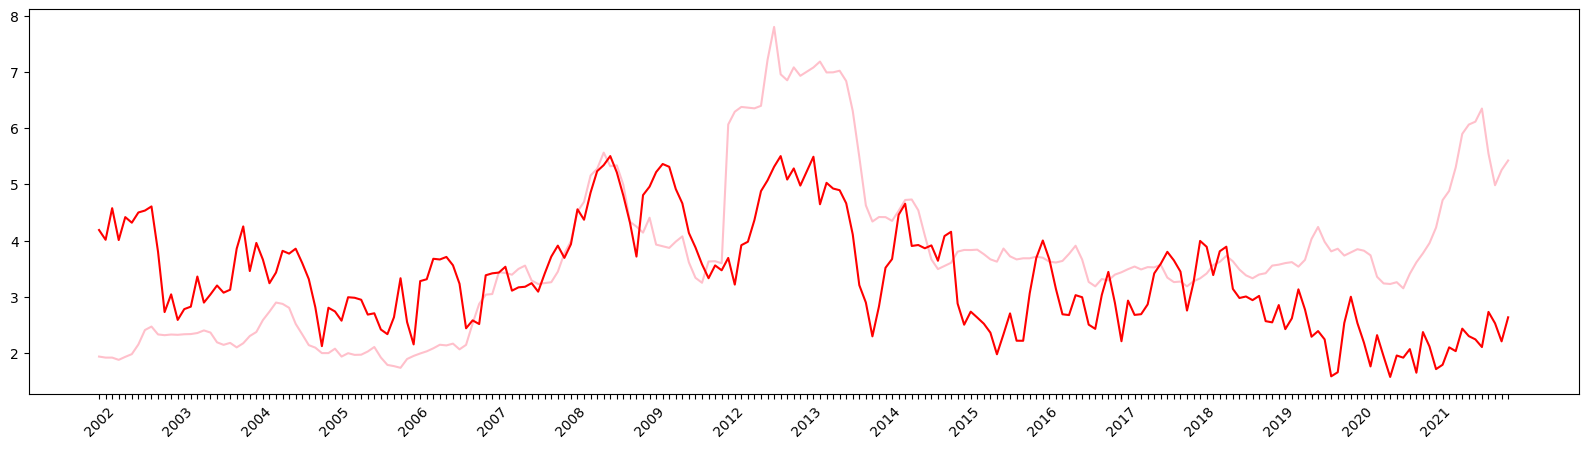

,YEAR,MONTH,TMIN-0,TMAX-0,PRCP-0,TMIN-1,TMAX-1,PRCP-1,TMIN-2,TMAX-2,...,PRCP-8,TMIN-9,TMAX-9,PRCP-9,TMIN-10,TMAX-10,PRCP-10,TMIN-11,TMAX-11,PRCP-11
211,2021,8,17.805743,29.630136,35.661556,17.827798,28.835632,35.675946,16.812338,29.017269,...,11.974720,1.035336,13.488326,20.142331,3.802575,15.787365,25.783436,11.595399,23.817290,25.753697
212,2021,9,13.104153,26.656812,22.168012,17.805743,29.630136,35.661556,17.827798,28.835632,...,17.411286,-5.422070,4.774975,11.974720,1.035336,13.488326,20.142331,3.802575,15.787365,25.783436
213,2021,10,9.064574,19.976947,40.502570,13.104153,26.656812,22.168012,17.805743,29.630136,...,11.920228,-6.098772,1.762769,17.411286,-5.422070,4.774975,11.974720,1.035336,13.488326,20.142331
214,2021,11,-1.110409,10.566895,9.291241,9.064574,19.976947,40.502570,13.104153,26.656812,...,28.304497,-12.118485,-2.355515,11.920228,-6.098772,1.762769,17.411286,-5.422070,4.774975,11.974720
215,2021,12,-2.883559,8.131697,17.075810,-1.110409,10.566895,9.291241,9.064574,19.976947,...,21.696206,0.548692,12.908095,28.304497,-12.118485,-2.355515,11.920228,-6.098772,1.762769,17.411286


In [ ]:
split_year = 2017

X_train = X[X["YEAR"]<split_year][columns]
y_train = y[y["YEAR"]<split_year]['PRICE']
X_test =  X[X["YEAR"]>=split_year][columns]
y_test = y[y["YEAR"]>=split_year]['PRICE']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

label = np.where(y['MONTH'] == 1, y['YEAR'].astype(str), "")
date =y['YEAR'].astype(str)+"/"+y['MONTH'].astype(str)
y_pred = model.predict(X[columns])
plt.figure(figsize=(20, 5))
plt.plot(date,y['PRICE'],color="pink")
plt.plot(date,y_pred,color="red")
plt.xticks(ticks=range(len(label)),labels=label, rotation=45)
plt.show()

X.tail()

In [ ]:
corn_production = pd.read_csv('../data/crop_data/corn.csv')
# Filter for corn grain only
cleaned_df = corn_production[corn_production['COMMODITY'] == "CORN, GRAIN"]
# Creates separate dataframes for year and marketing year rows
year_df = cleaned_df[cleaned_df['REFERENCE PERIOD'] == 'YEAR'].copy()
marketing_year_df = cleaned_df[cleaned_df['REFERENCE PERIOD'] == 'MARKETING YEAR'].copy()
# Creates a mapping of (location, year) to price
price_mapping = marketing_year_df.set_index(['LOCATION', 'YEAR'])['PRICE RECEIVED in $ / BU']
# Map the prices to the year rows using location and year as keys
year_df['PRICE RECEIVED in $ / BU'] = year_df.apply(
    lambda row: price_mapping.get((row['LOCATION'], row['YEAR']), None),
    axis=1
)
# This will be our final dataframe
cleaned_df = year_df
# Drop unnecessary columns
corn_production = cleaned_df.drop(["PRODUCTION in $","PRICE RECEIVED in $ / BU","REFERENCE PERIOD","YIELD in BU / ACRE","PRODUCTION in TONS", "COMMODITY", "ASD CODE", "COUNTY ANSI", "AREA PLANTED in ACRES", "YIELD in TONS / ACRE", "STATE ANSI"], axis=1)
corn_production = corn_production.rename(columns={
    "LOCATION": "STATE",
    "AREA HARVESTED in ACRES": "ACRES",
    "PRODUCTION in BU":"PRODUCTION",
})
corn_production = corn_production[corn_production["STATE"].isin(corn_belt_states)]
corn_production["ACRES"] = corn_production["ACRES"].str.replace(",", "").astype(int)
corn_production["PRODUCTION"] = corn_production["PRODUCTION"].str.replace(",", "").astype(int)

production = corn_production[corn_production['YEAR']>2000]
production = production[["YEAR","PRODUCTION","ACRES"]].groupby(["YEAR"]).sum().reset_index()
print(production)

    YEAR  PRODUCTION     ACRES
0   2001  6580830000  45040000
1   2002  6291700000  44990000
2   2003  7041460000  45760000
3   2004  8193470000  47640000
4   2005  7687080000  48570000
5   2006  7463700000  46440000
6   2007  8801230000  53980000
7   2008  8161270000  49030000
8   2009  8759350000  49700000
9   2010  8282490000  50590000
10  2011  8353950000  52300000
11  2012  6864770000  53060000
12  2013  8831480000  52110000
13  2014  9194490000  50800000
14  2015  8960430000  50040000
15  2016  9711060000  51270000
16  2017  9463820000  49130000
17  2018  9495100000  48730000
18  2019  8684830000  47550000
19  2020  9155060000  49900000
20  2021  9637240000  49260000
21  2022  9223610000  47570000
22  2023  9792280000  49990000
23  2024  9910580000  48580000


In [225]:
price = cpm[["YEAR","PRICE"]].groupby(["YEAR"]).mean().reset_index()
print(price)

    YEAR     PRICE
0   2001  1.876111
1   2002  2.132361
2   2003  2.268611
3   2004  2.447361
4   2005  1.933750
5   2006  2.263889
6   2007  3.383194
7   2008  4.796667
8   2009  3.768194
9   2010  3.846667
10  2011  6.055417
11  2012  6.721250
12  2013  6.188611
13  2014  4.124167
14  2015  3.740000
15  2016  3.529861
16  2017  3.409444
17  2018  3.488056
18  2019  3.784722
19  2020  3.532639
20  2021  5.396389
21  2022  6.695278
22  2023  5.915417
23  2024  4.301481


(9, 2)
(9,)
(15, 2)
(15,)
Mean Absolute Error (MAE): 1.2677520047374504
R² Score: -1.1064999341062443


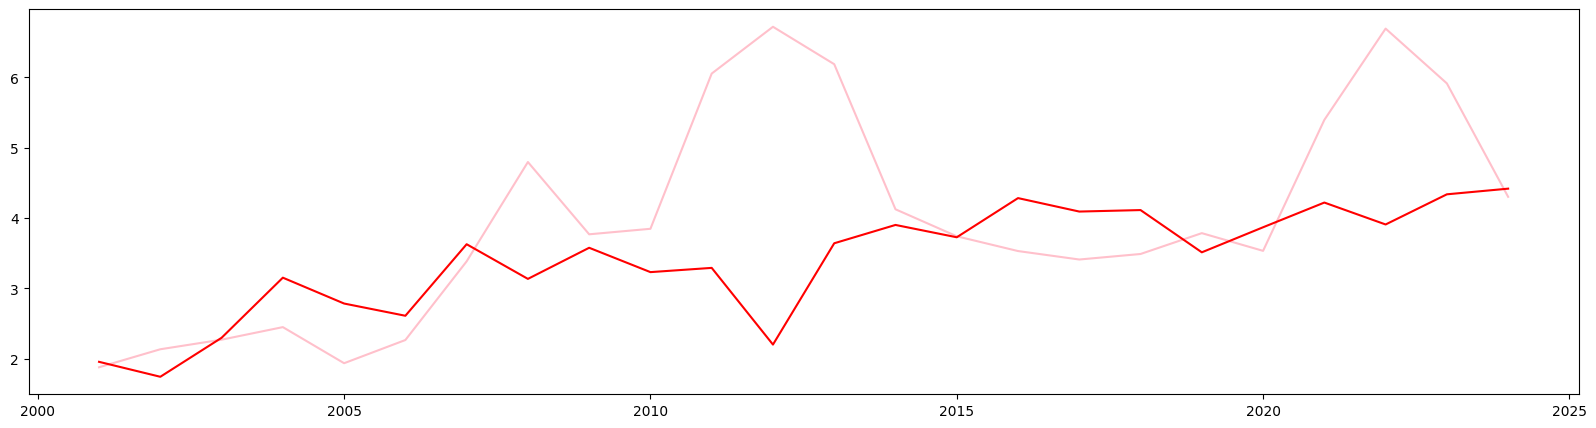

Weights: [7.35175485e-10 4.57828549e-09]
Intercept: -3.090695559744808


In [255]:
split_year = 2010
X_train = production[production["YEAR"]<split_year][["PRODUCTION","ACRES"]]
y_train = price[price["YEAR"]<split_year]['PRICE']
X_test =  production[production["YEAR"]>=split_year][["PRODUCTION","ACRES"]]
y_test = price[price["YEAR"]>=split_year]['PRICE']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

date = price['YEAR']
y_pred = model.predict(production[["PRODUCTION","ACRES"]])
plt.figure(figsize=(20, 5))
plt.plot(date,price['PRICE'],color="pink")
plt.plot(date,y_pred,color="red")
plt.show()

weights = model.coef_ 
intercept = model.intercept_ 
print("Weights:", weights)
print("Intercept:", intercept)


(8, 3)
(8,)
(15, 3)
(15,)
Mean Absolute Error (MAE): 0.7447283668390848
R² Score: 0.2711796956847724


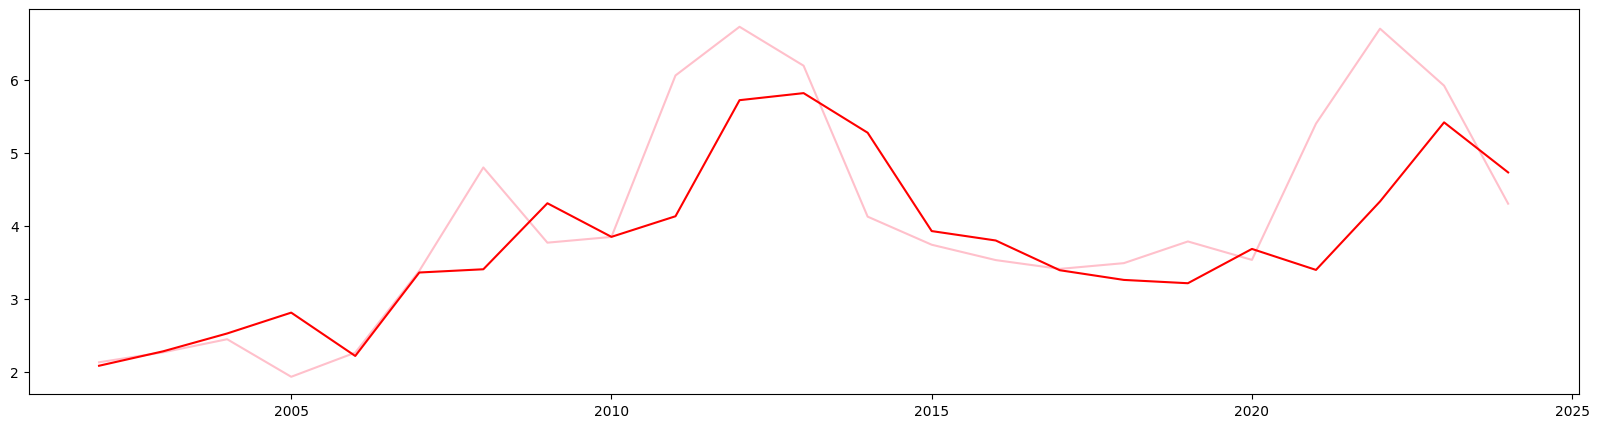

Weights: [-8.96086447e-11  1.40568479e-07  6.10062068e+00]
Intercept: -4.820356303668666


In [ ]:
# useless!!! because all the weight is put on the price of the previous year, getting a shifted curve


price_old = price.copy()
price_old = price_old.rename(columns={"PRICE": "OLD_PRICE"})
price_old['YEAR']=price_old['YEAR']+1
price_old['OLD_PRICE']=price_old['OLD_PRICE']/10
price_old.head()
features = production.merge(price_old,left_on='YEAR', right_on='YEAR', how='inner')
output = price[price["YEAR"]>2001]

split_year = 2010
X_train = features[features["YEAR"]<split_year][["PRODUCTION","ACRES","OLD_PRICE"]]
y_train = output[output["YEAR"]<split_year]['PRICE']
X_test =  features[features["YEAR"]>=split_year][["PRODUCTION","ACRES","OLD_PRICE"]]
y_test = output[output["YEAR"]>=split_year]['PRICE']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

date = output['YEAR']
y_pred = model.predict(features[["PRODUCTION","ACRES","OLD_PRICE"]])
plt.figure(figsize=(20, 5))
plt.plot(date,output['PRICE'],color="pink")
plt.plot(date,y_pred,color="red")
plt.show()

weights = model.coef_ 
intercept = model.intercept_ 
print("Weights:", weights)
print("Intercept:", intercept)


